<a href="https://colab.research.google.com/github/CS-Abdulaziz/animal-parts-segmentation-pytorch/blob/main/animals_parts_sugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammad2012191/segmentation")   # Multiclass segmentation + unsplitted

print("Path to dataset files:", path)

100%|██████████| 192M/192M [00:05<00:00, 34.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohammad2012191/segmentation/versions/1


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import glob
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np

# This function is defined to give each unique pixel a class value started with 0
def remap_mask(mask):

    mask = mask.long()
    unique_values = torch.unique(mask)
    remapped_mask = torch.zeros_like(mask)

    for new_val, old_val in enumerate(sorted(unique_values.tolist())):
        remapped_mask[mask == old_val] = new_val

    return remapped_mask

In [ ]:
# extracting the paths of train & validation
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')


In [ ]:
# Difining the dataset class

class AnimalsPartsDataset(Dataset):

  def __init__(self, root_dir, image_transform = None, mask_trasnfoem = None):

    self.root_dir = root_dir
    self.images = glob.glob(f'{self.root_dir}/images/*.jpg')
    self.mask = glob.glob(f'{self.root_dir}/masks/*.png')

    self.images.sort()
    self.mask.sort()

    self.image_transform = image_transform
    self.mask_transform = mask_trasnfoem

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):

    image_path = self.images[idx]
    mask_path = self.mask[idx]

    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')

    if self.image_transform:
        image = self.image_transform(image)

    if self.mask_transform:
        mask = self.mask_transform(mask)

    mask = mask.squeeze(0).long()
    mask = remap_mask(mask)

    return image, mask


In [ ]:
from torch.utils.data import DataLoader

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),  # Keep segmentation masks intact
    transforms.PILToTensor(),

])

train_dataset = AnimalsPartsDataset(train_path, image_transforms, mask_transforms)
val_dataset = AnimalsPartsDataset(val_path, image_transforms, mask_transforms)

train_dataset[0]

(tensor([[[-0.5140, -0.4981, -0.5401,  ..., -0.7248, -0.8848, -0.8646],
          [-0.5003, -0.5050, -0.5571,  ..., -0.7798, -0.8529, -0.8533],
          [-0.5106, -0.4772, -0.5816,  ..., -0.8023, -0.8075, -0.7845],
          ...,
          [ 0.7325,  0.8799,  0.8839,  ...,  0.5577,  0.8569,  1.1148],
          [ 0.5350,  0.6587,  0.4401,  ...,  0.4505,  0.5291,  0.9887],
          [ 0.5147,  0.6174,  0.5325,  ...,  0.6097,  0.7370,  1.0364]],
 
         [[-0.2434, -0.2182, -0.2487,  ..., -0.5537, -0.6934, -0.6821],
          [-0.2225, -0.2149, -0.2601,  ..., -0.6133, -0.6741, -0.6734],
          [-0.2198, -0.1767, -0.2830,  ..., -0.6395, -0.6423, -0.6176],
          ...,
          [ 0.8694,  1.0548,  1.0528,  ...,  0.7383,  1.0687,  1.3402],
          [ 0.6607,  0.8225,  0.5996,  ...,  0.6528,  0.7423,  1.2201],
          [ 0.6273,  0.7622,  0.7002,  ...,  0.8334,  0.9571,  1.2743]],
 
         [[-0.4776, -0.5156, -0.6087,  ..., -0.6741, -0.8579, -0.8578],
          [-0.5136, -0.5842,

In [ ]:
img, mask = train_dataset[0]

print(torch.unique(mask))
print(mask.min(), mask.max())

tensor([0, 1, 2, 3])
tensor(0) tensor(3)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# Check dataset sizes
print(f"Training Samples: {len(train_dataset)}, Testing Samples: {len(val_dataset)}")

Training Samples: 1737, Testing Samples: 435


In [ ]:
images, masks = next(iter(train_loader))

print(masks.shape)
print(masks.dtype)

torch.Size([4, 256, 256])
torch.int64


In [ ]:
images, masks = next(iter(train_loader))

print(torch.unique(masks))
print(masks.max())

tensor([0, 1, 2, 3, 4])
tensor(4)


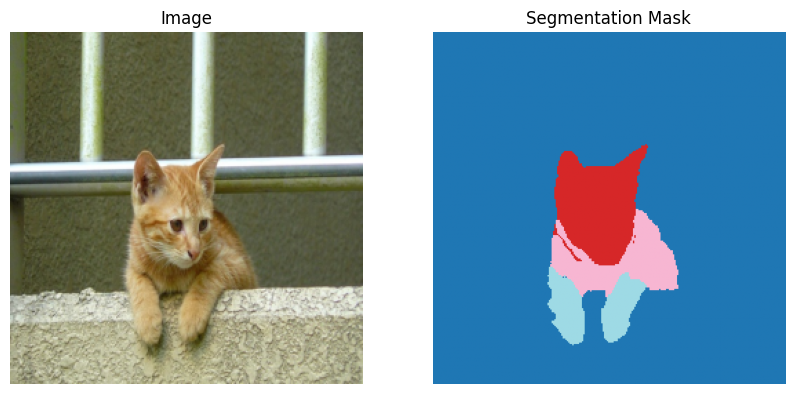

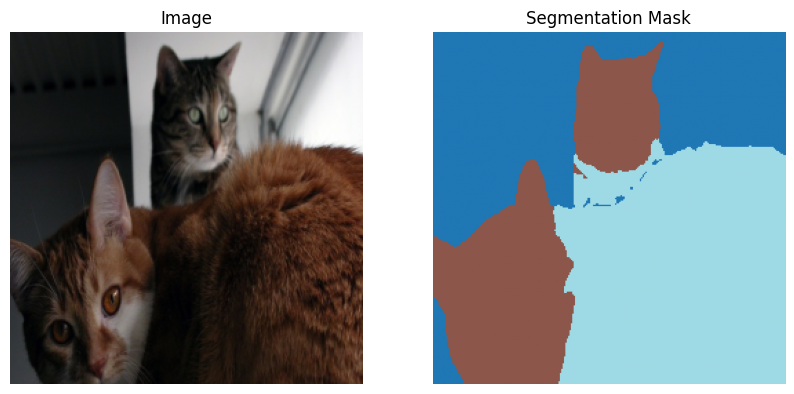

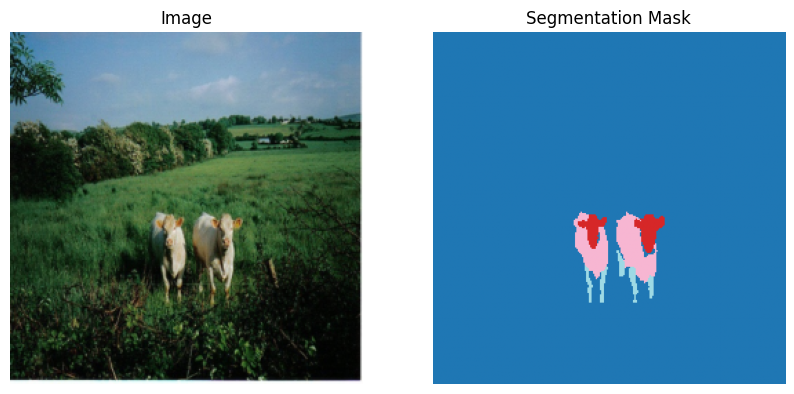

In [ ]:
import matplotlib.pyplot as plt

# Function to denormalize images (We cannot show normalized images. We have to reverse normalizaion first.)
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img

# Display some images with their masks
for i in range(3):

    img, mask = train_dataset[i]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(denormalize(img))
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="tab20")
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    plt.show()



In [ ]:
!pip install -q segmentation_models_pytorch

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Training
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import segmentation_models_pytorch as smp

# Define U-Net Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = smp.Unet(
    encoder_name="efficientnet-b0",  # Pretrained encoder (backbone)
    encoder_weights="imagenet",  # Using ImageNet weights
    in_channels=3,  # RGB images
    classes=24,
).to(device)

In [ ]:
import torch
from torch import nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 5  # Define number of epochs
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 435/435 [00:45<00:00,  9.61it/s]


Epoch 1/5: Train Loss = 1.5046, Val Loss = 0.5358


100%|██████████| 435/435 [00:36<00:00, 11.88it/s]


Epoch 2/5: Train Loss = 0.4953, Val Loss = 0.3659


100%|██████████| 435/435 [00:36<00:00, 11.81it/s]


Epoch 3/5: Train Loss = 0.3745, Val Loss = 0.3236


100%|██████████| 435/435 [00:37<00:00, 11.69it/s]


Epoch 4/5: Train Loss = 0.3199, Val Loss = 0.2986


100%|██████████| 435/435 [00:35<00:00, 12.20it/s]


Epoch 5/5: Train Loss = 0.2853, Val Loss = 0.2814


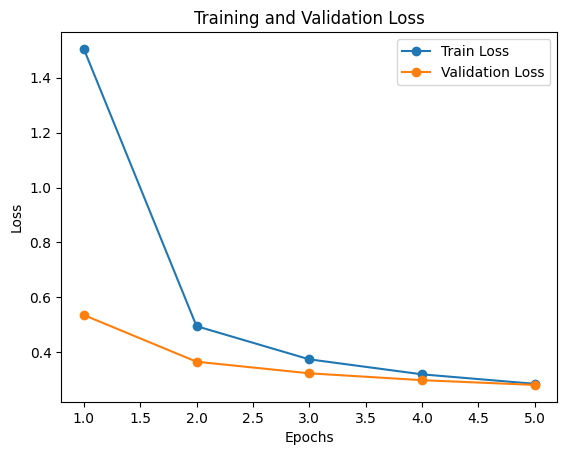

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

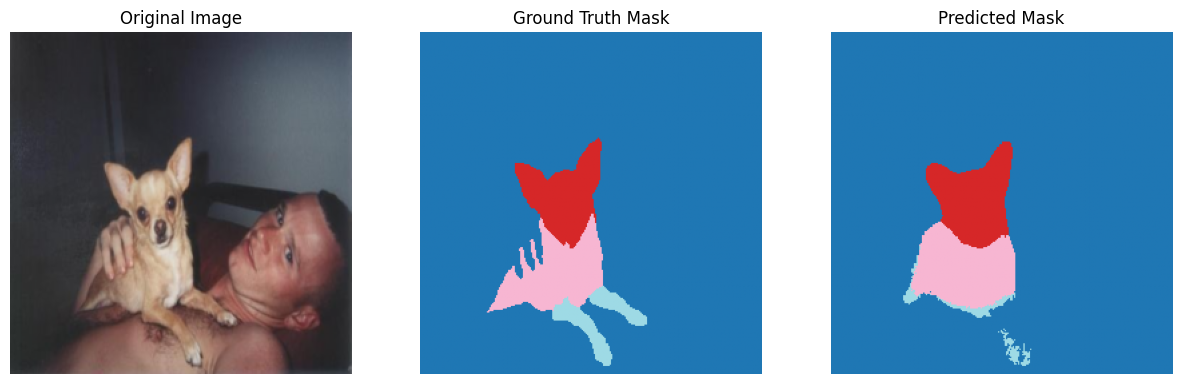

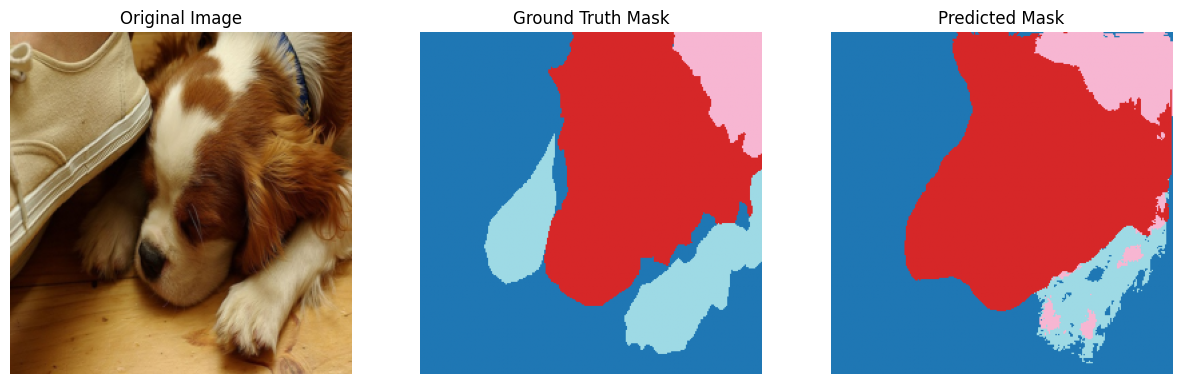

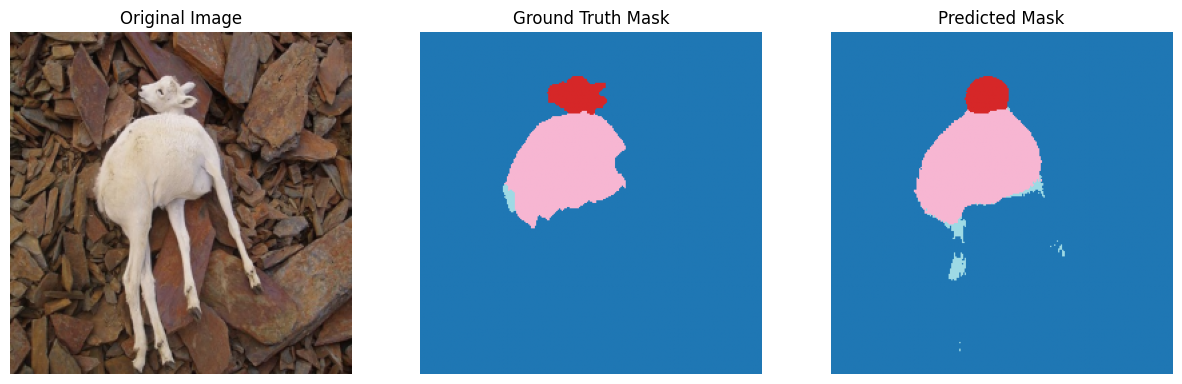

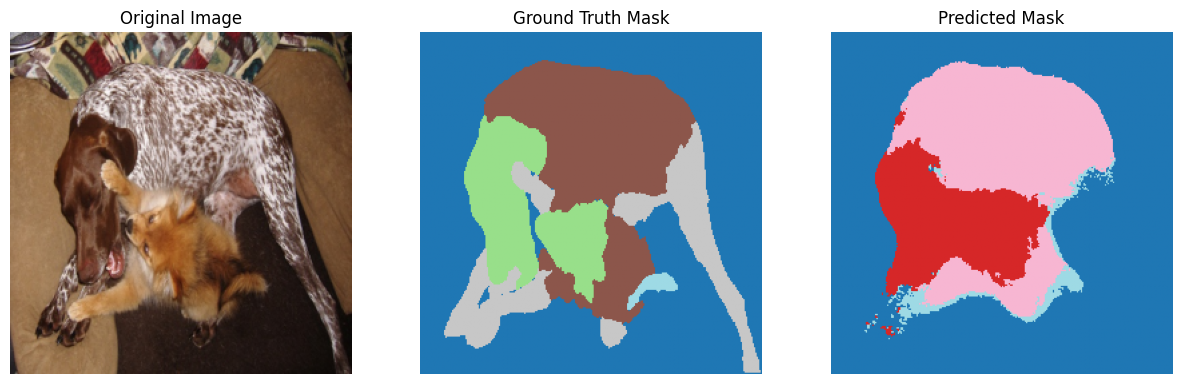

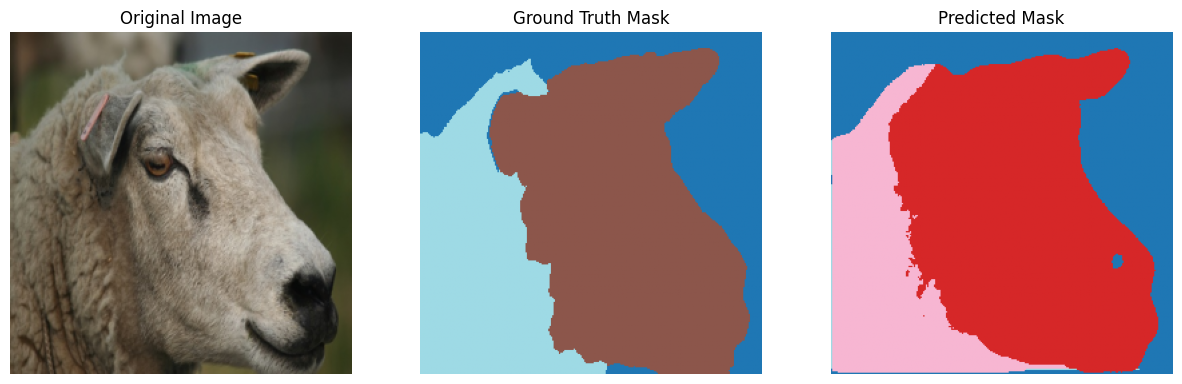

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize images
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img

# Set model to evaluation mode
model.eval()

# Get some test samples
test_samples = random.sample(range(len(val_dataset)), 5)

for idx in test_samples:
    img, mask = val_dataset[idx]

    with torch.no_grad():
        pred_mask = model(img.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred_mask, dim=1)

    pred_mask = pred_mask.cpu().squeeze().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(denormalize(img))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="tab20")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(pred_mask, cmap="tab20")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()
